# PyTorchモデルも簡単変換で高速推論 - ![OpenVINO](resources/openvino.png) Toolkit

## 推論入力データ(画像)とラベルファイルを読み込む

ラベルデータ: ['n01440764 tench, Tinca tinca', 'n01443537 goldfish, Carassius auratus', 'n01484850 great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 'n01491361 tiger shark, Galeocerdo cuvieri', 'n01494475 hammerhead, hammerhead shark', 'n01496331 electric ray, crampfish, numbfish, torpedo', 'n01498041 stingray', 'n01514668 cock', 'n01514859 hen', 'n01518878 ostrich, Struthio camelus']


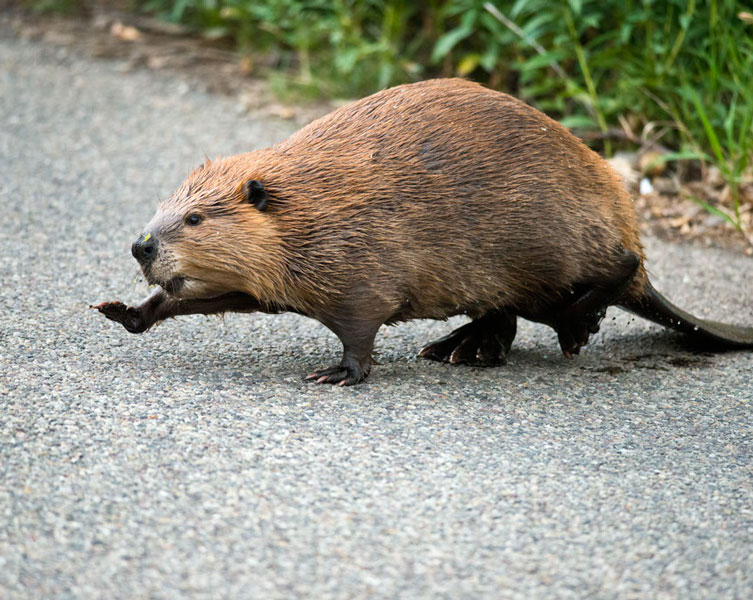

In [1]:
import time
from pathlib import Path
from PIL import Image
import numpy as np

DATA_DIR = Path('data')
MODEL_DIR = Path('model')
MODEL_NAME = 'resnet50'

image = Image.open('data/beaver.jpg')                        # イメージファイルを読み込み

labels_file = DATA_DIR / 'imagenet_2012.txt'   
imagenet_classes = labels_file.open("r").read().splitlines() # ラベルデータ読み込み

print(f'ラベルデータ: {imagenet_classes[:10]}')
image

## PyTorch (Torchvision)の学習済みResnet50モデルを読み込み

In [2]:
import torch
import torchvision

print(f'PyTorch version : {torch.__version__}')

weights = torchvision.models.ResNet50_Weights.DEFAULT
pyt_model = torchvision.models.resnet50(weights=weights, progress=True).to('cpu')   # Torchvisionの学習済みResNet50モデルを読み込み

pyt_model.eval();     # 推論モードに切り替え

# 推論入力画像の前加工
preprocess = weights.transforms()
img_transformed = preprocess(image)
input_tensor = img_transformed.unsqueeze(0)

PyTorch version : 1.13.1+cpu


## PyTorchで推論実行

In [3]:
niter = 100

pyt_model(input_tensor)                   # 初回推論遅延を除外するため１度推論を実行

stime = time.perf_counter()
for _ in range(niter):
    result = pyt_model(input_tensor)      # 推論を繰り返し実行してパフォーマンス計測
etime = time.perf_counter()

perf_pytorch = niter/(etime-stime)
print(f'推論パフォーマンス PyTorch = {perf_pytorch:8.3f} inf/sec')

推論パフォーマンス PyTorch =   11.901 inf/sec


## PyTorchでの推論結果を表示

In [4]:
result_np = result.to('cpu').detach().numpy().copy().ravel()
sorted = np.argsort(result_np)[::-1][:5]       # 結果をソートして、top 5を取り出す

print(f'Top 5 results = {sorted}')

for i, cls in enumerate(sorted):
    print(f'{i+1} : {imagenet_classes[cls]}')  # 推論結果の表示

Top 5 results = [337 360 336 106 357]
1 : n02363005 beaver
2 : n02444819 otter
3 : n02361337 marmot
4 : n01883070 wombat
5 : n02442845 mink


## PyTorchのモデルを![OpenVINO](resources/openvino.png)用に変換

In [5]:
import openvino as ov

core = ov.Core()                                                  # OpenVINOのコアオブジェクトを生成

print(f'OpenVINO version : {ov.__version__}')

stime = time.perf_counter()
ov_model = ov.convert_model(pyt_model)                            # PyTorchのモデルをOpenVINO形式(IR model)に変換！
etime = time.perf_counter()
print(f'PyTorch->OpenVINOモデル変換時間: {etime-stime:8.3f} sec')

ov.save_model(ov_model, MODEL_DIR / f'{MODEL_NAME}_dynamic.xml')  # 変換済みモデルをファイルとして保存 (オプション)

OpenVINO version : 2023.1.0-12185-9e6b00e51cd-releases/2023/1
PyTorch->OpenVINOモデル変換時間:    0.824 sec


## ![OpenVINO](resources/openvino.png) IRモデルを指定推論デバイス用にコンパイル
### デバイス特化モデル生成
OpenVINO IRモデルを推論ターゲットデバイス向けにコンパイルします。キャッシュディレクトリの指定はオプションです。キャッシュディレクトリを指定すると、２回目以降はコンパイル済みモデルデータを利用するのでモデルコンパイル時間を短縮可能です。

In [6]:
device = 'CPU'     # CPU / GPU / GPU.0 / GPU.1
compiled_model = core.compile_model(ov_model, device, config={ov.properties.cache_dir(): './model_cache'}) 

## ![OpenVINO](resources/openvino.png)で推論実行
### PyTorchとパフォーマンス比較

In [7]:
niter = 100

compiled_model(input_tensor)               # 初回推論遅延を除外するため１度推論を実行

stime = time.perf_counter()
for _ in range(niter):
    result = compiled_model(input_tensor)  # 推論を繰り返し実行してパフォーマンス計測
etime = time.perf_counter()
perf_openvino = niter/(etime-stime)

print(f'推論パフォーマンス OpenVINO ({device}) = {perf_openvino:8.3f} inf/sec')
print(f'推論パフォーマンス PyTorch        = {perf_pytorch:8.3f} inf/sec')

print(f'パフォーマンス比   OpenVINO / PyTorch = {perf_openvino / perf_pytorch:8.3f} times')

推論パフォーマンス OpenVINO (CPU) =   57.419 inf/sec
推論パフォーマンス PyTorch        =   11.901 inf/sec
パフォーマンス比   OpenVINO / PyTorch =    4.825 times


## ![OpenVINO](resources/openvino.png)での推論結果を表示

In [8]:
result = result[0].ravel()
sorted = np.argsort(result)[::-1][:5]

print(f'Top 5 results = {sorted}')

for i in sorted:
    print(imagenet_classes[i])

Top 5 results = [337 360 336 106 357]
n02363005 beaver
n02444819 otter
n02361337 marmot
n01883070 wombat
n02442845 mink


# ![OpenVINO](resources/openvino.png) Toolkitは無償のツールです。
# 推論パフォーマンスが大幅に向上しますのでぜひお試しください！

In [9]:
from platform import processor
import psutil

total_mem = psutil.virtual_memory()[0]/pow(2,30)
cpu_freq = psutil.cpu_freq()[0]/1e3
proc_name = processor()

print(f'Procssor    : {proc_name},  ClkSpd : {cpu_freq}GHz')
print(f'Total memory: {total_mem:6.1f}GB')

Procssor    : Intel64 Family 6 Model 165 Stepping 5, GenuineIntel,  ClkSpd : 3.792GHz
Total memory:   31.8GB
